# Ion Temperature Gradient Drift Dispersion (Kappa Distribution)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import plasmapy
from scipy import special as sp
import scipy.optimize as op
from tqdm import tqdm
%config InlineBackend.figure_format = 'svg'

In [2]:
plt.rcParams.update({'font.size': 16})
plt.rcParams.update({'lines.linewidth': 2})

In [3]:
mi2me = 1836
L_t2rho_i = 10
wp_i2wc_i = 100
ky_rho_i = 0.1

kappa_e = 3
kappa_i = 3
fke = np.sqrt(kappa_e/(kappa_e-0.5))
fki = np.sqrt(kappa_i/(kappa_i-0.5))

In [4]:
terms = 300 # number of terms for the integration
gl_1 = sp.roots_genlaguerre(terms,kappa_i-0.5)
gl_2 = sp.roots_genlaguerre(terms,kappa_i-1.5)
gl_e = sp.roots_genlaguerre(terms,kappa_e-0.5)

def PDRM(w2wc,kz_rho_i,ve2vi):
    ky2kz = ky_rho_i/kz_rho_i
    ky_rho_e = ky_rho_i*ve2vi/mi2me
    k_l_Di = np.sqrt(ky_rho_i**2+kz_rho_i**2)/wp_i2wc_i
    k_l_De = k_l_Di*ve2vi/np.sqrt(mi2me)
    
    wr,wi=w2wc
    wc=complex(wr,wi)

    zeta_i = wc/np.sqrt(2)/kz_rho_i
    zeta_e = zeta_i/ve2vi
    zeta_ni = 0
    zeta_ti = ky2kz/L_t2rho_i/np.sqrt(2)
    g0 = sp.ive(0,ky_rho_i**2)
    g1 = sp.ive(1,ky_rho_i**2)
    
    re = 1 + (zeta_e)*plasmapy.dispersion.plasma_dispersion_func(zeta_e)*sp.ive(0,ky_rho_e**2)
    ri1 = (zeta_i-zeta_ni+0.5*zeta_ti)*plasmapy.dispersion.plasma_dispersion_func(zeta_i)*g0
    ri2 = zeta_ti*(0.5*zeta_i*plasmapy.dispersion.plasma_dispersion_func_deriv(zeta_i)*g0-plasmapy.dispersion.plasma_dispersion_func(zeta_i)*ky_rho_i**2*(g1-g0))
    ri = 1.0 + ri1 + ri2
    r =  1.0 + re/k_l_De**2 + ri/k_l_Di**2
    return [r.real,r.imag]

def PDRMK(w2wc,kz_rho_i,ve2vi):
    ky2kz = ky_rho_i/kz_rho_i
    ky_rho_e = ky_rho_i*ve2vi/mi2me
    k_l_Di = np.sqrt(ky_rho_i**2+kz_rho_i**2)/wp_i2wc_i*fki
    k_l_De = k_l_Di*ve2vi/np.sqrt(mi2me)/fki
    
    wr,wi=w2wc
    wc=complex(wr,wi)

    zeta_i = wc/np.sqrt(2)/kz_rho_i
    zeta_e = zeta_i/ve2vi
    zeta_ni = 0
    zeta_ti = 1.0/np.sqrt(2)*ky2kz/L_t2rho_i*kappa_i/(kappa_i-1.5)

    K1_integrad = lambda bi: np.sqrt(bi) * ( zeta_i - zeta_ni*(kappa_i-3/2)/kappa_i/bi + 0.5*zeta_ti*(kappa_i-3/2)/kappa_i/bi )*plasmapy.dispersion.plasma_dispersion_func(zeta_i*np.sqrt(bi))*sp.ive(0,ky_rho_i**2/bi)

    K2_integrad = lambda bi: zeta_ti * ( 0.5*zeta_i*bi*plasmapy.dispersion.plasma_dispersion_func_deriv(zeta_i*np.sqrt(bi))*sp.ive(0,ky_rho_i**2/bi) - plasmapy.dispersion.plasma_dispersion_func(zeta_i*np.sqrt(bi)) * ky_rho_i**2/np.sqrt(bi) * (sp.ive(1,ky_rho_i**2/bi)-sp.ive(0,ky_rho_i**2/bi)) )

    ri1 =  np.dot(gl_1[1],K1_integrad(gl_1[0]/kappa_i))/sp.gamma(kappa_i+0.5)
    ri2 =  np.dot(gl_2[1],K2_integrad(gl_2[0]/kappa_i))/sp.gamma(kappa_i+0.5)*(kappa_i-1.5)

    re = 1 + (zeta_e)*plasmapy.dispersion.plasma_dispersion_func(zeta_e)*sp.ive(0,ky_rho_e**2)
    ri = 1.0 + ri1 + ri2
    r =  1.0 + re/k_l_De**2 + ri/k_l_Di**2

    return [r.real,r.imag]

def PDRKM(w2wc,kz_rho_i,ve2vi):
    ky2kz = ky_rho_i/kz_rho_i
    ky_rho_e = ky_rho_i*ve2vi/mi2me
    k_l_Di = np.sqrt(ky_rho_i**2+kz_rho_i**2)/wp_i2wc_i
    k_l_De = k_l_Di*ve2vi/np.sqrt(mi2me)*fke
    
    wr,wi=w2wc
    wc=complex(wr,wi)

    zeta_i = wc/np.sqrt(2)/kz_rho_i
    zeta_e = zeta_i/ve2vi
    zeta_ni = 0
    zeta_ti = 1.0/np.sqrt(2)*ky2kz/L_t2rho_i

    g0 = sp.ive(0,ky_rho_i**2)
    g1 = sp.ive(1,ky_rho_i**2)

    Ke_integrad = lambda be: np.sqrt(be) * zeta_e * plasmapy.dispersion.plasma_dispersion_func(zeta_e*np.sqrt(be))*sp.ive(0,ky_rho_e**2/be)
    re = 1.0 + np.dot(gl_e[1],Ke_integrad(gl_e[0]/kappa_e))/sp.gamma(kappa_e+0.5)

    ri1 = (zeta_i-zeta_ni+0.5*zeta_ti)*plasmapy.dispersion.plasma_dispersion_func(zeta_i)*g0
    ri2 = zeta_ti*(0.5*zeta_i*plasmapy.dispersion.plasma_dispersion_func_deriv(zeta_i)*g0-plasmapy.dispersion.plasma_dispersion_func(zeta_i)*ky_rho_i**2*(g1-g0))
    ri = 1.0 + ri1 + ri2

    r =  1.0 + re/k_l_De**2 + ri/k_l_Di**2

    return [r.real,r.imag]

def PDRK(w2wc,kz_rho_i,ve2vi):
    ky2kz = ky_rho_i/kz_rho_i
    ky_rho_e = ky_rho_i*ve2vi/mi2me
    k_l_Di = np.sqrt(ky_rho_i**2+kz_rho_i**2)/wp_i2wc_i*fki
    k_l_De = k_l_Di*ve2vi/np.sqrt(mi2me)/fki*fke
    
    wr,wi=w2wc
    wc=complex(wr,wi)

    zeta_i = wc/np.sqrt(2)/kz_rho_i
    zeta_e = zeta_i/ve2vi
    zeta_ni = 0
    zeta_ti = 1.0/np.sqrt(2)*ky2kz/L_t2rho_i*kappa_i/(kappa_i-1.5)

    Ke_integrad = lambda be: np.sqrt(be) * zeta_e * plasmapy.dispersion.plasma_dispersion_func(zeta_e*np.sqrt(be))*sp.ive(0,ky_rho_e**2/be)
    K1_integrad = lambda bi: np.sqrt(bi) * ( zeta_i - zeta_ni*(kappa_i-3/2)/kappa_i/bi + 0.5*zeta_ti*(kappa_i-3/2)/kappa_i/bi )*plasmapy.dispersion.plasma_dispersion_func(zeta_i*np.sqrt(bi))*sp.ive(0,ky_rho_i**2/bi)
    K2_integrad = lambda bi: zeta_ti * ( 0.5*zeta_i*bi*plasmapy.dispersion.plasma_dispersion_func_deriv(zeta_i*np.sqrt(bi))*sp.ive(0,ky_rho_i**2/bi) - plasmapy.dispersion.plasma_dispersion_func(zeta_i*np.sqrt(bi)) * ky_rho_i**2/np.sqrt(bi) * (sp.ive(1,ky_rho_i**2/bi)-sp.ive(0,ky_rho_i**2/bi)) )

    re =  1.0 + np.dot(gl_e[1],Ke_integrad(gl_e[0]/kappa_e))/sp.gamma(kappa_e+0.5)
    ri1 = np.dot(gl_1[1],K1_integrad(gl_1[0]/kappa_i))/sp.gamma(kappa_i+0.5)
    ri2 = np.dot(gl_2[1],K2_integrad(gl_2[0]/kappa_i))/sp.gamma(kappa_i+0.5)*(kappa_i-1.5)

    ri = 1.0 + ri1 + ri2
    r =  1.0 + re/k_l_De**2 + ri/k_l_Di**2

    return [r.real,r.imag]

In [5]:
ks_pow = -5
ke_pow = -1.8
ks = 10**ks_pow
ke = 10**ke_pow
pow_idx = np.linspace(ks_pow,ke_pow,num=400)
kz_rho_i_list = 10**pow_idx

In [6]:
ve2vi_1 = 100
ve2vi_2 = 150
ve2vi_3 = 200
mth = 'hybr' # root finding method

In [7]:
def CaluDiffT(ve2vi):
    w_theo = 0.5*(1.0/L_t2rho_i*ky_rho_i*ks**2*ve2vi**2/mi2me)**(1/3)
    r_theo = 0.5*np.sqrt(3)*(1.0/L_t2rho_i*ky_rho_i*ks**2*ve2vi**2/mi2me)**(1/3)

    wguess_m = w_theo*0.5
    rguess_m = r_theo*0.1
    wguess_k = w_theo*0.8
    rguess_k = r_theo*0.5

    sM=op.root(lambda w:PDRM(w,ks,ve2vi),[wguess_m,rguess_m],method=mth)
    wguess_k = sM.x[0]*0.8
    rguess_k = sM.x[1]*0.8
    sMK=op.root(lambda w:PDRMK(w,ks,ve2vi),[wguess_k,rguess_k],method=mth)
    sKM=op.root(lambda w:PDRKM(w,ks,ve2vi),[wguess_k,rguess_k],method=mth)
    sK=op.root(lambda w:PDRK(w,ks,ve2vi),[wguess_k,rguess_k],method=mth)
    print('M',sM.success)
    print(sM.x[0],sM.x[1])
    print('MK',sMK.success)
    print(sMK.x[0],sMK.x[1])
    print('KM',sKM.success)
    print(sKM.x[0],sKM.x[1])
    print('K',sK.success)
    print(sK.x[0],sK.x[1])

    w_M_list = []
    r_M_list = []
    w_MK_list = []
    r_MK_list = []
    w_KM_list = []
    r_KM_list = []
    w_K_list = []
    r_K_list = []

    wgm =wguess_m
    rgm =rguess_m
    wgmk =wguess_k
    rgmk =rguess_k
    wgkm =wguess_k
    rgkm =rguess_k
    wgk =wguess_k
    rgk =rguess_k

    for ki in tqdm(kz_rho_i_list):
        sM=op.root(lambda w:PDRM(w,ki,ve2vi),[wgm,rgm],method=mth)
        w_M_list.append(sM.x[0])
        r_M_list.append(sM.x[1])
        wgm = round(sM.x[0],6)
        rgm = round(sM.x[1],6)
        
        sMK=op.root(lambda w:PDRMK(w,ki,ve2vi),[wgmk,rgmk],method=mth)
        w_MK_list.append(sMK.x[0])
        r_MK_list.append(sMK.x[1])
        wgmk = round(sMK.x[0],6)
        rgmk = round(sMK.x[1],6)

        sKM=op.root(lambda w:PDRKM(w,ki,ve2vi),[wgkm,rgkm],method=mth)
        w_KM_list.append(sKM.x[0])
        r_KM_list.append(sKM.x[1])
        wgkm = round(sKM.x[0],6)
        rgkm = round(sKM.x[1],6)

        sK=op.root(lambda w:PDRK(w,ki,ve2vi),[wgk,rgk],method=mth)
        w_K_list.append(sK.x[0])
        r_K_list.append(sK.x[1])
        wgk = round(sK.x[0],6)
        rgk = round(sK.x[1],6)
    return r_M_list,r_MK_list,r_KM_list,r_K_list

In [8]:
r_M_list_1,r_MK_list_1,r_KM_list_1,r_K_list_1 = CaluDiffT(ve2vi_1)
r_M_list_2,r_MK_list_2,r_KM_list_2,r_K_list_2 = CaluDiffT(ve2vi_2)
r_M_list_3,r_MK_list_3,r_KM_list_3,r_K_list_3 = CaluDiffT(ve2vi_3)

M True
0.00011503267010177857 2.47710719877293e-06
MK True
0.00011624208256715768 -4.7077319356640715e-06
KM True
0.00011241488645067972 1.8423220141400566e-06
K True
0.00011513589438285655 -4.9222746884630525e-06


  0%|          | 0/400 [00:00<?, ?it/s]

100%|██████████| 400/400 [00:02<00:00, 179.46it/s]


M True
0.00010743054487245054 4.7140287715640787e-07
MK True
0.00011281400415005276 -5.560290146089792e-06
KM True
0.00010657473681231561 3.8873337014953806e-07
K True
0.00011238834999578863 -5.610272578406012e-06


100%|██████████| 400/400 [00:02<00:00, 178.44it/s]


M True
0.00010527316166081442 1.749773277529768e-07
MK True
0.00011172277103010172 -5.740935875170237e-06
KM True
0.00010483582683034415 1.4796543444548795e-07
K True
0.00011149464417267318 -5.761863793857656e-06


100%|██████████| 400/400 [00:02<00:00, 177.75it/s]


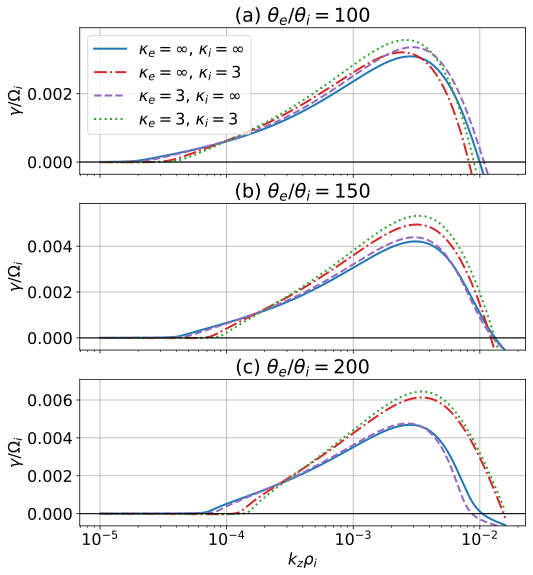

In [10]:
xticks = 10**np.linspace(ks_pow,-2,num=-2-ks_pow+1)
ylim1 = np.max([r_M_list_1,r_MK_list_1,r_K_list_1])
ylim2 = np.max([r_M_list_2,r_MK_list_2,r_K_list_2])
ylim3 = np.max([r_M_list_3,r_MK_list_3,r_K_list_3])
fig = plt.figure(figsize=(8,9))

ax1 = plt.subplot(311)
ax1.plot(kz_rho_i_list,r_M_list_1, label=r'$\kappa_e=\infty$, $\kappa_i=\infty$',color='tab:blue', linestyle='-')
ax1.plot(kz_rho_i_list,r_MK_list_1, label=r'$\kappa_e=\infty$, $\kappa_i=$'+str(kappa_i), color='tab:red', linestyle='-.')
ax1.plot(kz_rho_i_list,r_KM_list_1, label=r'$\kappa_e=$'+str(kappa_e)+r', $\kappa_i=\infty$', color='tab:purple', linestyle='--')
ax1.plot(kz_rho_i_list,r_K_list_1, label=r'$\kappa_e=$'+str(kappa_e)+', $\kappa_i=$'+str(kappa_i), color='tab:green', linestyle=':')
ax1.set_title(r'(a) $\theta_e/\theta_i=100$')
ax1.axhline(0,color='black',linewidth=1.1)
ax1.set_ylabel(r'$\gamma/\Omega_i$')
ax1.set_xscale('log')
ax1.set_ylim(-0.1*ylim1,ylim1*1.1)
ax1.set_xticks(xticks,())
ax1.grid()
ax1.legend()

ax2 = plt.subplot(312)
ax2.plot(kz_rho_i_list,r_M_list_2, label=r'$\kappa_e=\infty$, $\kappa_i=\infty$',color='tab:blue', linestyle='-')
ax2.plot(kz_rho_i_list,r_MK_list_2, label=r'$\kappa_e=\infty$, $\kappa_i=$'+str(kappa_i), color='tab:red', linestyle='-.')
ax2.plot(kz_rho_i_list,r_KM_list_2, label=r'$\kappa_e=$'+str(kappa_e)+r', $\kappa_i=\infty$', color='tab:purple', linestyle='--')
ax2.plot(kz_rho_i_list,r_K_list_2, label=r'$\kappa_e=$'+str(kappa_e)+', $\kappa_i=$'+str(kappa_i), color='tab:green', linestyle=':')
ax2.set_title(r'(b) $\theta_e/\theta_i=150$')
ax2.axhline(0,color='black',linewidth=1.1)
ax2.set_ylabel(r'$\gamma/\Omega_i$')
ax2.set_xscale('log')
ax2.set_ylim(-0.1*ylim2,ylim2*1.1)
ax2.set_xticks(xticks,())
ax2.grid()

ax3 = plt.subplot(313)
ax3.plot(kz_rho_i_list,r_M_list_3, label=r'$\kappa_e=\infty$, $\kappa_i=\infty$',color='tab:blue', linestyle='-')
ax3.plot(kz_rho_i_list,r_MK_list_3, label=r'$\kappa_e=\infty$, $\kappa_i=$'+str(kappa_i), color='tab:red', linestyle='-.')
ax3.plot(kz_rho_i_list,r_KM_list_3, label=r'$\kappa_e=$'+str(kappa_e)+r', $\kappa_i=\infty$', color='tab:purple', linestyle='--')
ax3.plot(kz_rho_i_list,r_K_list_3, label=r'$\kappa_e=$'+str(kappa_e)+', $\kappa_i=$'+str(kappa_i), color='tab:green', linestyle=':')
ax3.set_title(r'(c) $\theta_e/\theta_i=200$')
ax3.axhline(0,color='black',linewidth=1.1)
ax3.set_xlabel(r'$k_z\rho_i$')
ax3.set_ylabel(r'$\gamma/\Omega_i$')
ax3.set_xscale('log')
ax3.set_ylim(-0.1*ylim3,ylim3*1.1)
ax3.set_xticks(xticks)
ax3.grid()

# plt.savefig('./fig2_gamma_vs_kzrhoi.pdf', bbox_inches='tight')
plt.show()